# Import Library

In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D

2023-07-16 01:38:11.981174: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-16 01:38:12.109697: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


# Data Exploration

In [2]:
images_folder = '/home/images/'
listimg = os.listdir(images_folder)
EXAMPLE_IMG = plt.imread(images_folder + np.random.choice(listimg))

In [3]:
EXAMPLE_IMG.shape

(218, 178, 3)

In [4]:
# import dataset
df_attr = pd.read_csv('/home/list_attr_celeba.csv')
df_attr.set_index('image_id', inplace=True)
df_attr.replace(to_replace=-1, value=0, inplace=True) #replace -1 by 0
df_attr.shape

(202599, 40)

In [5]:
try:
  df_attr.loc[listimg]
except Exception as e:
  print(e)

"['182793(1).jpg', '182809(1).jpg', '182912(1).jpg', '182943(1).jpg', '183005(1).jpg', '183018(1).jpg', '183050(1).jpg', '183111(1).jpg', '183121(1).jpg', '183145(1).jpg', '189132(1).jpg', '189297(1).jpg', '189324(1).jpg', '189512(1).jpg', '189513(1).jpg', '189581(1).jpg', '189651(1).jpg'] not in index"


Ditemukan beberapa file duplikat yang ditandai oleh (1) di akhir nama file

In [6]:
uniquelist = [img for img in listimg if not img.endswith("(1).jpg")]
uniquelist

['000051.jpg',
 '000065.jpg',
 '000052.jpg',
 '000166.jpg',
 '000198.jpg',
 '000201.jpg',
 '000240.jpg',
 '000282.jpg',
 '000352.jpg',
 '000409.jpg',
 '000414.jpg',
 '000439.jpg',
 '000444.jpg',
 '000474.jpg',
 '000525.jpg',
 '000545.jpg',
 '000572.jpg',
 '000559.jpg',
 '000608.jpg',
 '000653.jpg',
 '000716.jpg',
 '000771.jpg',
 '000810.jpg',
 '000798.jpg',
 '000845.jpg',
 '000858.jpg',
 '000873.jpg',
 '000922.jpg',
 '000989.jpg',
 '001140.jpg',
 '001161.jpg',
 '001218.jpg',
 '001242.jpg',
 '001248.jpg',
 '001256.jpg',
 '001270.jpg',
 '001295.jpg',
 '001401.jpg',
 '001519.jpg',
 '001509.jpg',
 '001665.jpg',
 '001613.jpg',
 '001637.jpg',
 '001782.jpg',
 '001708.jpg',
 '001800.jpg',
 '001894.jpg',
 '001921.jpg',
 '001983.jpg',
 '002085.jpg',
 '002125.jpg',
 '002134.jpg',
 '002150.jpg',
 '002197.jpg',
 '002202.jpg',
 '002223.jpg',
 '002256.jpg',
 '002310.jpg',
 '002362.jpg',
 '002389.jpg',
 '002427.jpg',
 '002415.jpg',
 '002443.jpg',
 '002450.jpg',
 '002456.jpg',
 '002502.jpg',
 '002525.j

In [7]:
# Filter df atribut dengan list gambar yang unik
df_unique = df_attr.loc[uniquelist]

**Lihat gambar random dari dataset**

In [8]:
def contohgambar(imagelist):
  random_img = np.random.choice(imagelist)
  random_img_path = images_folder + random_img
  img = plt.imread(random_img_path)
  plt.imshow(img)
  print(df_unique.loc[random_img_path.split('/')[-1]][['Smiling','Male','Black_Hair']]) #some attributes

Smiling       1
Male          0
Black_Hair    0
Name: 177434.jpg, dtype: int64


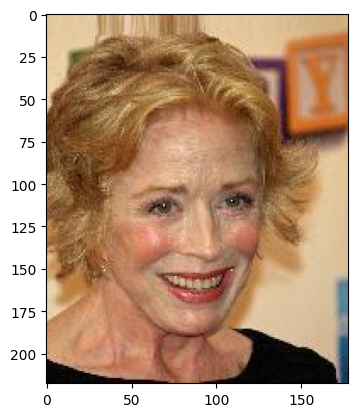

In [9]:
contohgambar(uniquelist)

**Distribusi Atribut**

Text(0, 0.5, 'Gender')

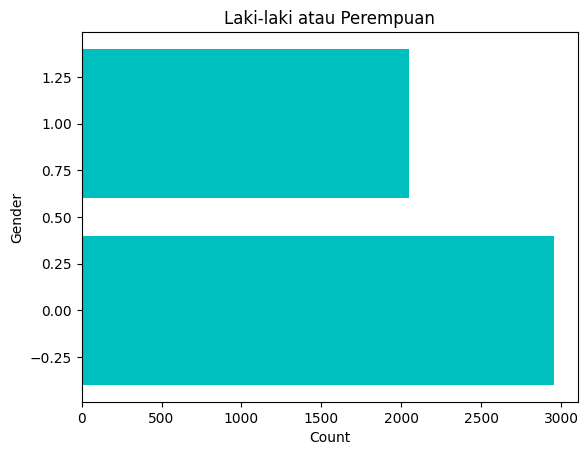

In [11]:
# # Laki-laki atau perempuan
counts = df_unique['Male'].value_counts()

# Create a bar plot
plt.barh(counts.index, counts.values, color='c')

# Set the title and axis labels
plt.title('Laki-laki atau Perempuan')
plt.xlabel('Count')
plt.ylabel('Gender')

# 2. Split Data to Train Validation, Test

In [12]:
def create_train_test(data):
    X = data.drop('Male', axis=1)
    y = data['Male']
    _, valtest, train, valtes = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    _, _, val, test = train_test_split(valtest, valtes, test_size=1/3, random_state=42, stratify=valtes)

    return train, val, test

In [13]:
train, val, test = create_train_test(df_unique)

In [14]:
def prosesdata(data):
    images = []
    for i in range(len(data)):
        img = plt.imread(images_folder + data.index[i])
        images.append(img / 255)
    y_ = tf.keras.utils.to_categorical(data)
    return np.array(images) , y_

In [15]:
trainX, trainy = prosesdata(train)
valX, valy = prosesdata(val)
testX, testy = prosesdata(test)

# 3. Build Model

In [16]:
# Import InceptionV3 Model
tl_model = tf.keras.applications.Xception(weights='imagenet',
                        include_top=False,
                        input_shape=(218, 178, 3))

print("number of layers:", len(tl_model.layers))
#inc_model.summary()

2023-07-16 01:39:21.180506: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-16 01:39:21.299130: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1637] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14944 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1c:00.0, compute capability: 7.5


83683744/83683744 [==============================] - 5s 0us/step
number of layers: 132


In [17]:
tl_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 218, 178, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 108, 88, 32)  864         ['input_1[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 108, 88, 32)  128        ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                           

In [18]:
# Lock initial layers to do not be trained
for layer in tl_model.layers[:-30]:
    layer.trainable = False
for layer in tl_model.layers[-30:]:
    layer.trainable = True

#Adding custom Layers
x = tl_model.output
x = Flatten()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
predictions = Dense(2, activation="softmax")(x)

# creating the final model
model = Model(inputs=tl_model.input, outputs=predictions)


# compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001)
                    , loss='categorical_crossentropy'
                    , metrics=['accuracy'])

In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 218, 178, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 108, 88, 32)  864         ['input_1[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 108, 88, 32)  128        ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                              

In [21]:
checkpointer = ModelCheckpoint(filepath='/home/model/Xceptionnoaugmentation.h5',
                               verbose=1, save_best_only=True)

In [22]:
hist = model.fit(trainX, trainy
                     , validation_data = (valX, valy)
                      , epochs= 20
                      , callbacks=[checkpointer]
                      , verbose=1
                    )

Epoch 1/20


2023-07-16 01:40:36.739662: I tensorflow/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8700


110/110 [==============================] - ETA: 0s - loss: 0.2386 - accuracy: 0.9026
Epoch 1: val_loss improved from inf to 0.25761, saving model to /home/model/Xceptionnoaugmentation.h5
110/110 [==============================] - 16s 121ms/step - loss: 0.2386 - accuracy: 0.9026 - val_loss: 0.2576 - val_accuracy: 0.9280
Epoch 2/20
110/110 [==============================] - ETA: 0s - loss: 0.0795 - accuracy: 0.9706
Epoch 2: val_loss improved from 0.25761 to 0.20163, saving model to /home/model/Xceptionnoaugmentation.h5
110/110 [==============================] - 12s 105ms/step - loss: 0.0795 - accuracy: 0.9706 - val_loss: 0.2016 - val_accuracy: 0.9290
Epoch 3/20
109/110 [============================>.] - ETA: 0s - loss: 0.0363 - accuracy: 0.9871
Epoch 3: val_loss did not improve from 0.20163
110/110 [==============================] - 10s 92ms/step - loss: 0.0368 - accuracy: 0.9869 - val_loss: 0.3086 - val_accuracy: 0.9230
Epoch 4/20
109/110 [============================>.] - ETA: 0s - los

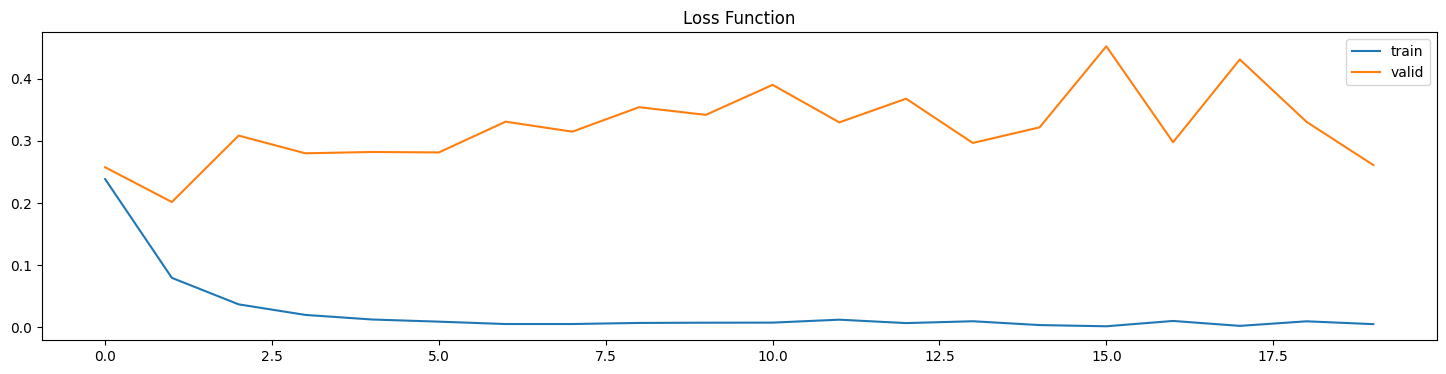

In [23]:
# Plot loss function value through epochs
plt.figure(figsize=(18, 4))
plt.plot(hist.history['loss'], label = 'train')
plt.plot(hist.history['val_loss'], label = 'valid')
plt.legend()
plt.title('Loss Function')
plt.show()

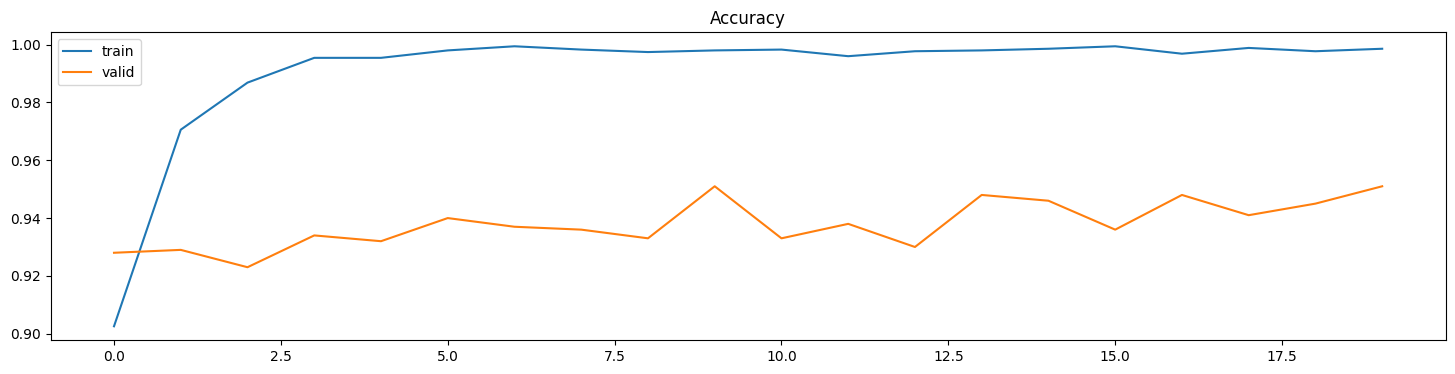

In [24]:
# Plot accuracy through epochs
plt.figure(figsize=(18, 4))
plt.plot(hist.history['accuracy'], label = 'train')
plt.plot(hist.history['val_accuracy'], label = 'valid')
plt.legend()
plt.title('Accuracy')
plt.show()

In [25]:
with open('/home/history/Xceptionnoaugmentation.pkl', 'wb') as file:
    pickle.dump(hist.history, file)

# Evaluasi

In [26]:
model = tf.keras.models.load_model('/home/model/Xceptionnoaugmentation.h5')

In [27]:
model.evaluate(testX, testy)

16/16 [==============================] - 2s 66ms/step - loss: 0.1936 - accuracy: 0.9520


[0.19361303746700287, 0.9520000219345093]

In [28]:
pred = model.predict(testX)

16/16 [==============================] - 2s 50ms/step


In [29]:
y_pred = np.argmax(pred, axis=1)
y_true = np.argmax(testy, axis=1)

In [30]:
false_predicted = []
for i in range(len(testX)):
    if y_pred[i] != y_true[i]:
        false_predicted.append((testX[i], y_pred[i]))

In [31]:
def plot_kesalahan():
    randnum = np.random.choice(np.arange(len(false_predicted)),8, replace=False)
    fig, axes = plt.subplots(2, 4)

    # Flatten the axes array for easier iteration
    axes = axes.flatten()
    
    # Plot each image in the corresponding subplot
    for i, idx in enumerate(randnum):
        axes[i].imshow(false_predicted[idx][0], cmap='gray')
        axes[i].set_title(f'Predicted {false_predicted[idx][1]}')
        axes[i].axis('off')

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Display the figure
    plt.show()

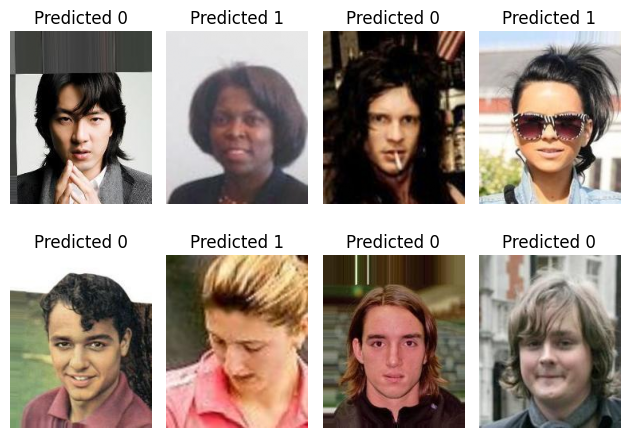

In [32]:
plot_kesalahan()

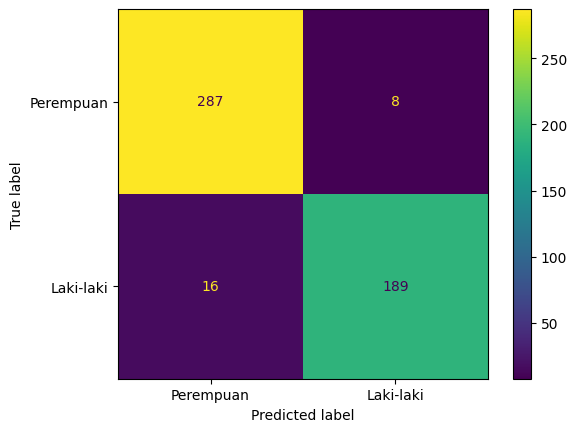

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Perempuan','Laki-laki'])
disp.plot()
plt.show()